In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from models import ValueIterationNetwork, softmax, GridWorldNode

from simulation_utils import get_optimal_sr_from_transitions
from environments import make_thread_the_needle, make_thread_the_needle_walls_moved_door
import environments as e


# Simulation 1: Change in transition matrix
Idea here is to calculate the computational cost, in resampling uniformly the transitions

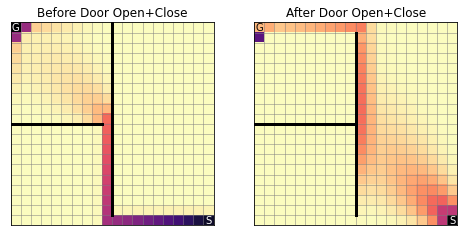

In [2]:
# define the enviornment
n_rows, n_columns = 20, 20


gamma = 0.95


sr_kwargs = dict(n_rows=n_rows, n_columns=n_columns, gamma=gamma)



fig, axes = plt.subplots(1, 2, figsize=(8, 4))    



transition_functions, reward_functions, optimal_policy = make_thread_the_needle(
    n_rows=n_rows,
    n_columns=n_columns,
    movement_penalty=0.01,
    slip_probability=0.05,
    random_movement_on_error=False,
    sparse=False,
)

M = get_optimal_sr_from_transitions(transition_functions, optimal_policy, **sr_kwargs)
    
axes[0].imshow(M[-1,].reshape(20 ,20), origin='upper',  cmap='magma_r')
e.clean_up_thread_the_needle_plot(axes[0], n_rows, n_columns)
axes[0].annotate('G', (0, 0), ha='center', va='center', c='w')
axes[0].annotate('S', (n_rows-1, n_columns-1), ha='center', va='center', c='w')


transition_functions, _, _ = make_thread_the_needle(
    n_rows=n_rows,
    n_columns=n_columns,
    movement_penalty=0.01,
    slip_probability=0.05,
    random_movement_on_error=False,
    list_walls = make_thread_the_needle_walls_moved_door(n_columns),
    sparse=False,
)
optimal_policy = e.make_thread_the_needle_with_doors_optimal_policy(n_rows, n_columns)
M_post = get_optimal_sr_from_transitions(transition_functions, optimal_policy, **sr_kwargs)


axes[1].imshow(M_post[-1,].reshape(20 ,20), origin='upper', cmap='magma_r')
walls = e.make_thread_the_needle_walls_moved_door(n_columns)
e.clean_up_thread_the_needle_plot(axes[1], n_rows, n_columns, walls=walls)
axes[1].annotate('G', (0, 0), ha='center', va='center', c='k')
axes[1].annotate('S', (n_rows-1, n_columns-1), ha='center', va='center', c='w')

axes[0].set_title('Before Door Open+Close')
axes[1].set_title('After Door Open+Close')

plt.savefig('SuccessorRepresentation_transition_change.pdf', dpi=300)

In [3]:
np.dot(M.reshape(-1), M_post.reshape(-1)) / (np.linalg.norm(M.reshape(-1)) * np.linalg.norm(M_post.reshape(-1)))

0.3740397891989125

In [4]:
np.dot(M.dot(reward_functions), M_post.dot(reward_functions)) / (
    np.linalg.norm(M.dot(reward_functions)) *
    np.linalg.norm(M_post.dot(reward_functions))
)

0.8045461905504755

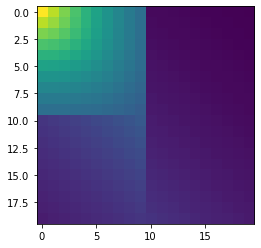

In [5]:
plt.imshow(M.dot(reward_functions).reshape(20, 20))

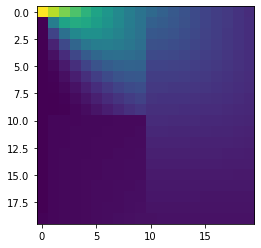

In [6]:
plt.imshow(M_post.dot(reward_functions).reshape(20, 20))

## MCTS simulations
These simulations are meant to show that the diffusion policy (a proxy for the stochastic simulation step) are not great for directed search. Has nothing to do with the SR -- and should be moved to a different notebook

In [7]:
n_rows, n_columns = 8, 8

import environments as e

gamma = 0.95



transition_functions, reward_functions, optimal_policy = environments.make_thread_the_needle(
    n_rows=n_rows,
    n_columns=n_columns,
    movement_penalty=0.01,
    slip_probability=0.05,
    random_movement_on_error=False,
    sparse=False,
)
M = get_optimal_sr_from_transitions(transition_functions, optimal_policy, n_rows, n_columns)


transition_functions_diffusion = [np.mean(transition_functions, axis=0) for _ in range(4)]

M_diff = get_optimal_sr_from_transitions(transition_functions_diffusion, optimal_policy)

plt.imshow(M_diff.dot(reward_functions).reshape(20, 20))

NameError: name 'environments' is not defined

In [ ]:
# plot the value function as a function of path distance to goal.
v_optimal = M.dot(reward_functions)
v_diffus = M_diff.dot(reward_functions)

In [ ]:
plt.imshow(v_optimal.reshape(n_rows, n_columns))

In [ ]:
# 
from simulation_utils import find_sortest_path_length, _get_neighbors
f = lambda s: find_sortest_path_length(v_optimal, 0, s, n_rows, n_columns)
distances_to_goal = np.array([
    f(s) for s in range(n_rows * n_columns)
])
plt.imshow(distances_to_goal.reshape(n_rows, n_columns))

In [ ]:
_get_neighbors(10, n_columns, n_rows)

In [ ]:
transition_functions[0][10].reshape(20, 20)

back to the SR!

In [ ]:
gamma = 0.99

transition_functions, _, optimal_policy = environments.make_thread_the_needle(
    n_rows=n_rows,
    n_columns=n_columns,
    movement_penalty=0.01,
    slip_probability=0.05,
    random_movement_on_error=False,
    sparse=False,
    list_walls=e.make_thread_the_needle_walls_moved_door(n_columns)
)

# turn optimal policy in to pmf
pi = optimal_policy * np.tile(1/ optimal_policy.sum(axis=1), (4, 1)).T

# marginalize out the optimal policy
T_sas = np.transpose(transition_functions, (1, 0, 2))
T_ss = np.array([T_sas[ii ,:].T.dot(pi[ii]) for ii in range(pi.shape[0])])

# calculate the SR
M =  np.linalg.inv(np.eye(400) - gamma * T_ss)



plt.imshow(M[-1,].reshape(20 ,20))

# Simulation 2: Policy Re-evaluation 


In [ ]:
# 1-D state-space with 20 states.  Start at state 4, goal at 0 (+1), loss at 8, (-1)
# optimal policy: left with 100%
# assume epsilon slip probability, so
# T(s, s') = s-1 with probability 1-epsilon


n_states = 20
start_state = n_states // 2 + 1
epsilon = 0.05



T_left = np.diag(np.ones(n_states-1), k=-1) * (1 - epsilon) \
    + np.diag(np.ones(n_states-1), k=1) * epsilon
# make the goal states terminal
T_left[0,0] = 1
T_left[0, 1:] = 0
T_left[-1, -1] = 1
T_left[-1, :-1] = 0

T_right = np.diag(np.ones(n_states-1), k=1) * (1 - epsilon) \
    + np.diag(np.ones(n_states-1), k=-1) * epsilon
# make the goal states terminal
T_right[0,0] = 1
T_right[0, 1:] = 0
T_right[-1, -1] = 1
T_right[-1, :-1] = 0


# optimal policy is always to go left
T_pi = np.copy(T_left)
T_df = np.copy(T_left + T_right) / 2

In [ ]:
# eqn 12 in Russek 2017

gamma = 0.8

M = np.linalg.inv(np.eye(n_states) - gamma * T_pi)
plt.imshow(M)
plt.xticks([ii for ii in range(4, 21, 5)], labels=[ii for ii in range(5, 21, 5)])
plt.yticks([ii for ii in range(4, 21, 5)], labels=[ii for ii in range(5, 21, 5)])


In [ ]:
R = np.zeros(n_states)
R[0] = 1
R[-1] = 0

# equation 6, Gershman J Neuro 2018
V = M.dot(R.reshape(-1, 1))
plt.bar(x=np.arange(1, n_states + 1), height=V.reshape(-1))
sns.despine()
# plt.xticks(np.arange(1, n_states + 1))
plt.xlabel('State')
plt.ylabel('State-Values')

In [ ]:
# This model is my own.  One step look-ahead Q-values where
# Q(s, a) = T(s, a, s')V(s')
# with a policy
# pi(s) ~ softmax[Q(s, a)]

beta = 10.

V = M.dot(R.reshape(-1, 1))
Q_left = T_left.dot(V).reshape(-1)
Q_right = T_right.dot(V).reshape(-1)
pi_correct_pre = np.exp(Q_left*beta) / (np.exp(Q_left*beta) + np.exp(Q_right*beta))
plt.plot(np.arange(2, n_states ), pi_correct_pre[1:-1], label='Optimal SR')

# plot the diffusion SR
M_df = np.linalg.inv(np.eye(n_states) - gamma * T_df)
V_df = M_df.dot(R.reshape(-1, 1))
Q_left_df = T_left.dot(V_df).reshape(-1)
Q_right_df = T_right.dot(V_df).reshape(-1)
pi_diff_pre = np.exp(Q_left_df*beta) / (np.exp(Q_left_df*beta) + np.exp(Q_right_df*beta))
plt.plot(np.arange(2, n_states ), pi_diff_pre[1:-1], label='Diffusion SR')

plt.plot(np.arange(2, n_states), np.ones(n_states-2) * 0.5, 'k:', label='chance')

plt.legend()
sns.despine()

In [ ]:
plt.plot(V)
plt.plot(V_df)

In [ ]:
# policy
# pi(s, a) = softmax(Q(s,a))

pi_correct_pre = np.exp(Q_left*beta) / (np.exp(Q_left*beta) + np.exp(Q_right*beta))
plt.plot(np.arange(2, n_states ), pi_correct_pre[1:-1], label='Optimal SR')

# plot the same thing but with the diffusion SR
M_df = np.linalg.inv(np.eye(n_states) - gamma * T_df)
V = M_df.dot(R.reshape(-1, 1))
Q_left = T_left.dot(V).reshape(-1)
Q_right = T_right.dot(V).reshape(-1)
pi_diff_pre = np.exp(Q_left*beta) / (np.exp(Q_left*beta) + np.exp(Q_right*beta))
plt.plot(np.arange(2, n_states ), pi_diff_pre[1:-1], label='Diffusion SR')

plt.legend()
sns.despine()

In [ ]:
M_df.shape

In [ ]:

R = np.zeros(9)
R[0] = 1
R[-1] = 2

# equation 6, Gershman J Neuro 2018
V = M.dot(R.reshape(-1, 1))
plt.bar(x=np.arange(1, 10), height=V.reshape(-1))
sns.despine()
plt.xticks(np.arange(1, 10))
plt.xlabel('State')
plt.ylabel('State-Values')

In [ ]:
V = M.dot(R.reshape(-1, 1))

# This model is my own.  One step look-ahead Q-values where
# Q(s, a) = T(s, a, s')V(s')

Q_left = T_left.dot(V).reshape(-1)
Q_right = T_right.dot(V).reshape(-1)

df = {
    'State': np.concatenate([np.arange(1, 10), np.arange(1, 10)]),
    'Q-value': np.concatenate([Q_left, Q_right]),
    'Action': ['Left'] * 9 + ['Right'] * 9
}


sns.barplot(x='State',y='Q-value', data=pd.DataFrame(df), hue='Action', palette='Set2')
sns.despine()

In [ ]:
# policy
# pi(s, a) = softmax(Q(s,a))
pi_correct_post = np.exp(Q_left) / (np.exp(Q_left) + np.exp(Q_right))
plt.bar(np.arange(2, 9), pi_correct_pre[1:-1])
plt.bar(np.arange(2, 9), pi_correct_post[1:-1])
plt.xlabel('Probablity of Left')
plt.ylabel('State')
sns.despine()

In [ ]:
# V = M.dot(R.reshape(-1, 1))
T_left.dot(V)

df = {
    'State': np.concatenate([np.arange(1, 10), np.arange(1, 10)]),
    'Q-value': np.concatenate([T_left.dot(V).reshape(-1), T_right.dot(V).reshape(-1)]),
    'Action': ['Left'] * 9 + ['Right'] * 9
}


sns.barplot(x='State',y='Q-value', data=pd.DataFrame(df), hue='Action', palette='Set2')
sns.despine()

In [ ]:
plt.plot((T_right + T_left).dot(V)
)


In [ ]:
M_df = np.linalg.inv(np.eye(9) - gamma * T_df)
V = M_df.dot(R.reshape(-1, 1))


plt.bar(x=np.arange(1, 10), height=V.reshape(-1))
sns.despine()
plt.xticks(np.arange(1, 10))
plt.xlabel('State')
plt.ylabel('State-Values')
plt.title('Diffusion policy')

In [ ]:
state_action_reward_functions = environments.get_state_action_reward_from_sucessor_rewards(
    R, [T_left, T_right]
)

sa_values, s_values = ValueIterationNetwork.value_iteration(
    [T_left, T_right], state_action_reward_functions, n_rows=1, n_columns=n_states, gamma=gamma)
s_values

In [ ]:
s_values

In [ ]:
plt.plot(V.reshape(-1))
plt.plot(s_values, )

In [ ]:
sa_values